# Unsupervised Learning Modeling

_Authors: Colleen Kenney_

---


## Contents

[1. Adding New Features](#1.-Adding-New-Features)<br>
[2. Creating Model Function](#2.-Creating-Model-Function)<br>
[3. Model Output](#3.-Model-Output)

### 1. Adding New Features

We wanted to add new features that would weight each category so we have features that weigh pricier establishments mores. This idea was inspired by https://github.com/twludlow/ga_project_4.

In [1]:
from sklearn.cluster import KMeans, k_means, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
restaurants = pd.read_csv('../data/aggregate_restaurants.csv')
shopping = pd.read_csv('../data/aggregate_shopping.csv')
nightlife = pd.read_csv('../data/aggregate_nightlife.csv')
beauty = pd.read_csv('../data/aggregate_beauty.csv')
hotels = pd.read_csv('../data/aggregate_hotels.csv')

In [3]:
def add_features(df):
    df['weighted_two_dollar'] = df['two_dollar'] * 2 
    df['weighted_three_dollar'] = df['three_dollar'] * 3
    df['weighted_four_dollar'] = df['four_dollar'] * 4
    df['total_businesses'] = df['one_dollar'] + df['two_dollar'] + df['three_dollar'] + df['four_dollar']
    
add_features(restaurants)
add_features(shopping)
add_features(nightlife)
add_features(beauty)
add_features(hotels)

### 2. Creating Model Function

In this section, we wanted to create a function that would return the number of clusters for a KMeans algorithm with the highest silhouette score. The silhouette score measures who similar a point is to it's own cluster (cohesion) compared to other clusters (separation). Silhouette scores of 1 are very good, -1 are bad, 0 is 'meh'. Inertia is another metric that we can optmize for. Inertia is the sum of squared errors for each cluster or how dense the cluster is. We chose to optimize for silhouette score, but we do take into account inertia in the results.

In [4]:
def kmeans (df):
    # drop non-numeric columns
    X = df.drop(columns=['city','city_median_household_income','abbrev_state']).astype(float)
    
    # scale data because Kmeans is distance based
    ss = StandardScaler()
    ss.fit(X)
    X_sc = ss.transform(X)
    scores = []
    
    # create dataframe that returns k, inertia, and silhouette for a range of ks
    for k in range(2, 40):
        cl = KMeans(n_clusters=k,random_state=42)
        cl.fit(X_sc)
        inertia = cl.inertia_
        sil = silhouette_score(X_sc, cl.labels_)
        scores.append([k, inertia, sil])
    
    score_df = pd.DataFrame(scores)
    score_df.columns = ['k', 'inertia', 'silhouette']
    
    # plot how inertia and silhouette score as k increases
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].plot(score_df.k, score_df.inertia)
    axes[0].set_title('Inertia over k')
    axes[1].plot(score_df.k, score_df.silhouette)
    axes[1].set_title('Silhouette Score over k')
    
    # get centroids using best k
    score_df[score_df['silhouette'] == score_df['silhouette'].max()]
    km = KMeans(n_clusters=score_df[score_df['silhouette'] == score_df['silhouette'].max()]['k'].values[0],
                random_state=42)
    km.fit(X_sc)
    centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_),columns=df.drop(
        columns=['city','city_median_household_income','abbrev_state']).columns)
    
    # get clusters for each city
    df['cluster'] = km.labels_
    
    print(score_df[score_df['silhouette'] == score_df['silhouette'].max()])
    return centroids, df[['city','abbrev_state','cluster']]
    

### 3. Model Output

In this section, we will run the kmeans clustering algorithm on each category to see how the patterns change.

   k     inertia  silhouette
1  3  323.140447    0.370538


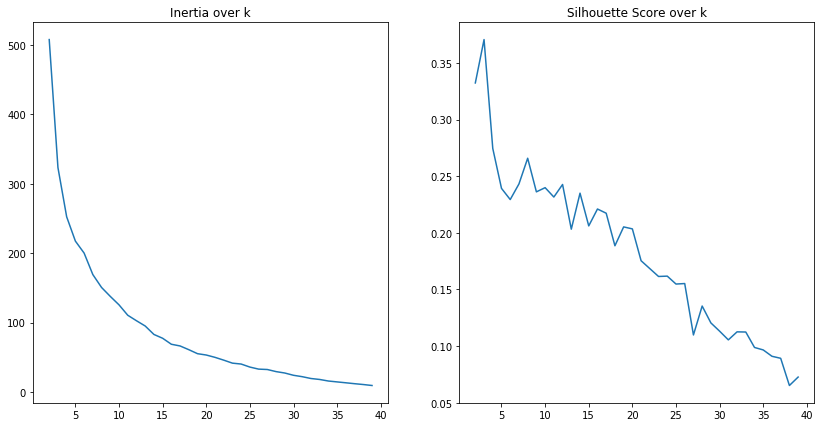

In [5]:
restaurant_centroids, restaurants_clusters = kmeans(restaurants)

In [6]:
restaurant_centroids

,average_rating_four_dollar,average_rating_one_dollar,average_rating_three_dollar,average_rating_two_dollar,average_review_count_four_dollar,average_review_count_one_dollar,average_review_count_three_dollar,average_review_count_two_dollar,four_dollar,one_dollar,three_dollar,two_dollar,weighted_two_dollar,weighted_three_dollar,weighted_four_dollar,total_businesses
0,2.451389,3.252680,3.761504,3.507619,40.069444,30.682077,99.844500,73.382529,0.916667,139.25000,9.833333,172.916667,345.833333,29.5000,3.666667,322.916667
1,4.053562,4.035381,3.889443,3.842161,1381.218059,1257.164859,1325.623947,1248.027421,17.000000,57.50000,69.500000,364.166667,728.333333,208.5000,68.000000,508.166667
2,3.914323,3.948346,3.942063,3.784273,341.115104,251.945788,359.794305,318.734617,3.000000,107.65625,29.437500,359.437500,718.875000,88.3125,12.000000,499.531250


In [7]:
restaurants_clusters.tail()

,city,abbrev_state,cluster
45,Burlington,VT,0
46,Virginia Beach,VA,2
47,Charleston,WV,0
48,Milwaukee,WI,2
49,Cheyenne,WY,0


The k with the highest silhouette score for restaurants was 3. That silhouette score was 0.370538. This is better than zero, but not quite as high as we'd like. With 3 clusters, inertia was 323. There seem to be 3 clusters, but they don't seem particularly cohesive or separate. The clusters also don't seem very dense. There are quite a few variables here to interpret in the centroids, but I will pick out a few that I think are interesting. Cluster 1 seems many more reviews for all price categories. Cluster one also seems to have much less ```$``` restaurants and much more ```$$$$``` restaurants. Cluster zero seems to be for cities with less than 500 businesses (average 309 businesses) and much less reviews.

   k     inertia  silhouette
0  2  527.422196    0.394976


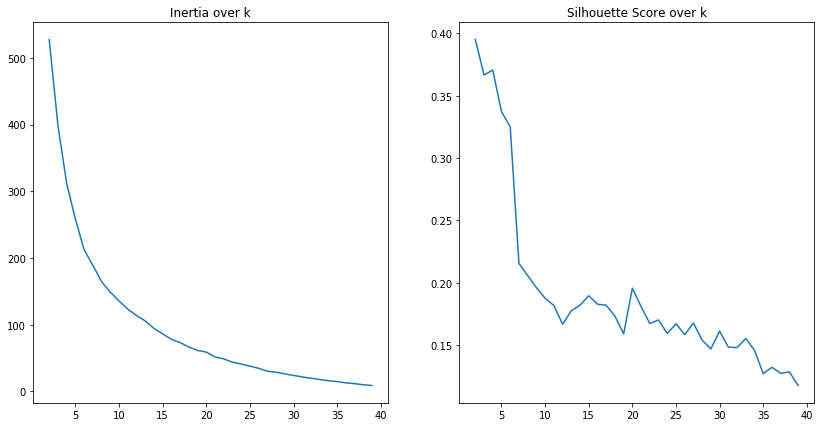

In [8]:
shopping_centroids, shopping_clusters = kmeans(shopping)

In [9]:
shopping_centroids

,average_rating_four_dollar,average_rating_one_dollar,average_rating_three_dollar,average_rating_two_dollar,average_review_count_four_dollar,average_review_count_one_dollar,average_review_count_three_dollar,average_review_count_two_dollar,four_dollar,one_dollar,three_dollar,two_dollar,weighted_two_dollar,weighted_three_dollar,weighted_four_dollar,total_businesses
0,3.336272,3.582555,3.547544,3.694748,43.632062,54.581129,55.897562,53.969740,12.594595,64.945946,77.324324,318.432432,636.864865,231.972973,50.378378,473.297297
1,2.889945,3.297984,3.363820,3.532141,6.559818,8.860117,11.526840,10.877289,6.642857,26.500000,35.142857,117.000000,234.000000,105.428571,26.571429,185.285714


In [10]:
shopping_clusters.head()

,city,abbrev_state,cluster
0,Birmingham,AL,0
1,Anchorage,AK,0
2,Phoenix,AZ,0
3,Chicago,IL,0
4,Little Rock,AR,1


For shopping, the k with the highest silhouette score was 2. That silhouette score was 0.394976 (slightly better than restaurants). This is better than zero, but stil not quite as high as we'd like. With 2 clusters, inertia was 527, so these clusters are less dense than restaurants. For these two clusters, cluster one seems to be for cities with much less businesses in total and less reviews.

   k     inertia  silhouette
0  2  501.381826    0.437782


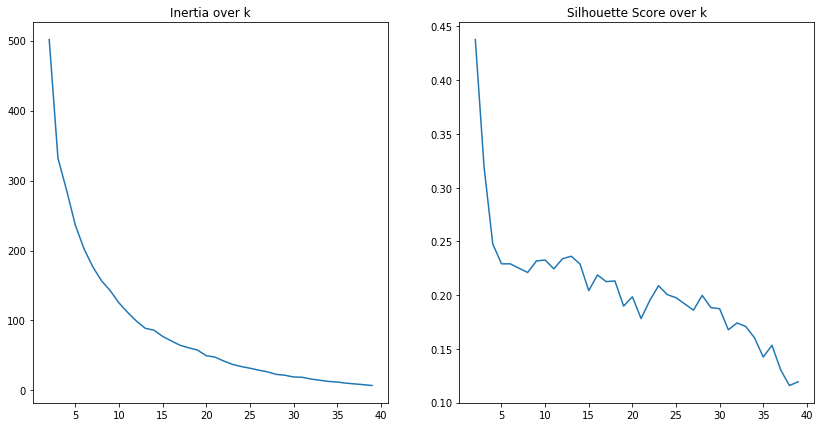

In [11]:
nightlife_centroids, nightlife_clusters = kmeans(nightlife)

In [12]:
nightlife_centroids

,average_rating_four_dollar,average_rating_one_dollar,average_rating_three_dollar,average_rating_two_dollar,average_review_count_four_dollar,average_review_count_one_dollar,average_review_count_three_dollar,average_review_count_two_dollar,four_dollar,one_dollar,three_dollar,two_dollar,weighted_two_dollar,weighted_three_dollar,weighted_four_dollar,total_businesses
0,4.010084,3.858561,3.864398,3.685625,842.774090,457.605711,735.087599,559.002675,8.500000,25.500000,60.750000,408.5,817.0,182.250000,34.000000,503.250000
1,3.022024,3.681255,3.673895,3.549295,100.406746,51.304205,171.163286,131.149160,1.833333,58.333333,14.547619,208.0,416.0,43.642857,7.333333,282.714286


In [13]:
nightlife_clusters.head()

,city,abbrev_state,cluster
0,Birmingham,AL,1
1,Anchorage,AK,1
2,Phoenix,AZ,0
3,Little Rock,AR,1
4,Los Angeles,CA,0


For nightlife, the k with the highest silhouette score was 2 again. That silhouette score was 0.437782 (slightly better than restaurants & shopping). This is better than zero, but stil not quite as high as we'd like. With 2 clusters, inertia was 501, so these clusters are less dense than restaurants but more dense than shopping. The clusters are similar to shopping in that cluster 1 seems to be for cities with much less businesses.

   k     inertia  silhouette
3  5  287.258028     0.29811


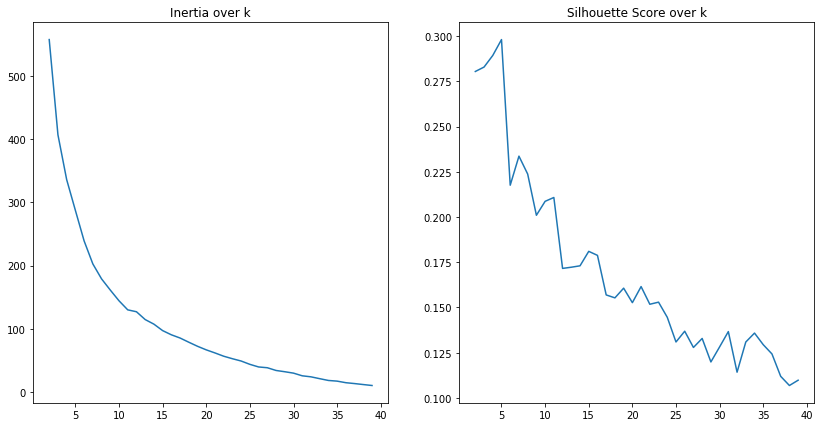

In [14]:
hotels_centroids, hotels_clusters = kmeans(hotels)

In [15]:
hotels_centroids

,average_rating_four_dollar,average_rating_one_dollar,average_rating_three_dollar,average_rating_two_dollar,average_review_count_four_dollar,average_review_count_one_dollar,average_review_count_three_dollar,average_review_count_two_dollar,four_dollar,one_dollar,three_dollar,two_dollar,weighted_two_dollar,weighted_three_dollar,weighted_four_dollar,total_businesses
0,1.477679,2.401669,3.166300,3.187173,27.264881,15.668076,70.423370,35.750407,0.785714,13.857143,8.035714,66.142857,132.285714,24.107143,3.142857,88.821429
1,4.025974,2.875000,3.573963,3.365985,343.142857,103.083333,329.701843,183.708361,9.000000,4.500000,66.000000,129.000000,258.000000,198.000000,36.000000,208.500000
2,3.262037,2.232574,3.461177,3.140439,72.210185,25.718159,130.798074,49.979101,2.444444,29.666667,30.277778,176.555556,353.111111,90.833333,9.777778,238.944444
3,3.875000,0.000000,3.558036,3.283871,236.062500,0.000000,247.151786,188.180645,16.000000,0.000000,112.000000,155.000000,310.000000,336.000000,64.000000,283.000000
4,3.416667,2.700000,3.690476,3.219298,257.000000,160.428571,1609.809524,527.818713,6.000000,35.000000,21.000000,171.000000,342.000000,63.000000,24.000000,233.000000


In [16]:
hotels_clusters.head()

,city,abbrev_state,cluster
0,Birmingham,AL,0
1,Anchorage,AK,0
2,Phoenix,AZ,2
3,Little Rock,AR,0
4,Los Angeles,CA,1


For hotels, the k with the highest silhouette score was actually 5. That silhouette score was 0.29811 (much worse than the first three). This is better than zero, but stil not quite as high as we'd like. With 5 clusters, inertia was 287, so these clusters are more dense than the first three. Cluster 3 seems to be for cities with much more expensive hotels.

   k     inertia  silhouette
1  3  411.430331    0.334008


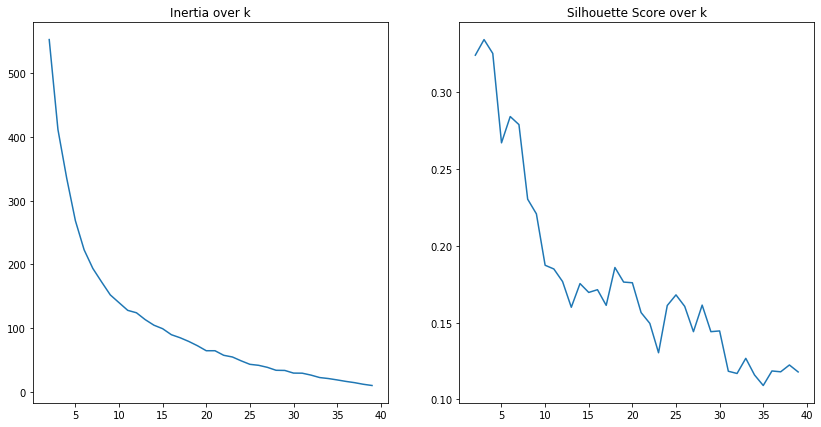

In [17]:
beauty_centroids, beauty_clusters = kmeans(beauty)

In [18]:
beauty_centroids

,average_rating_four_dollar,average_rating_one_dollar,average_rating_three_dollar,average_rating_two_dollar,average_review_count_four_dollar,average_review_count_one_dollar,average_review_count_three_dollar,average_review_count_two_dollar,four_dollar,one_dollar,three_dollar,two_dollar,weighted_two_dollar,weighted_three_dollar,weighted_four_dollar,total_businesses
0,2.781111,3.309384,3.249082,3.686702,6.218889,6.552022,10.317946,11.042765,2.20000,20.333333,14.533333,92.533333,185.066667,43.60000,8.800,129.60000
1,2.950574,3.754260,3.788235,3.819711,19.148968,36.828903,42.477709,43.823208,3.84375,63.062500,38.843750,340.781250,681.562500,116.53125,15.375,446.53125
2,3.758333,4.101200,4.030927,4.103457,155.116667,231.945980,246.061488,236.509372,3.00000,79.250000,47.750000,389.500000,779.000000,143.25000,12.000,519.50000


In [19]:
beauty_clusters.head()

,city,abbrev_state,cluster
0,Birmingham,AL,1
1,Charlotte,NC,1
2,Anchorage,AK,0
3,Phoenix,AZ,1
4,Little Rock,AR,0


For beauty, the k with the highest silhouette score was 3. That silhouette score was 0.334008 (slightly better than hotels but worse than the others). This is better than zero, but stil not quite as high as we'd like. With 3 clusters, inertia was 411, so these clusters are less dense than hotels and restaurants but more dense than the others. Cluster 2 seems to be for cities with many businesses as opposed to cluster zero.

Overall, there does seem to be some patterns in the data when taking into account all the yelp related variables (price, average rating per price, average review count per price, and total businesses). These clusters are not the strongest clusters in terms of silhouette score & inertia, but they do seem to exist. It is interesting how the clusters differ across each yelp category.